# Week 6 Tutorial


### Q1 

Consider the network for car diagnosis shown below.
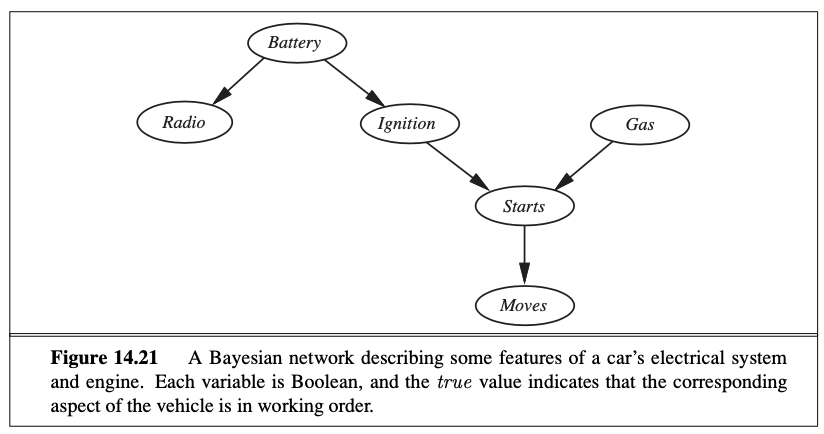

- **a**. Extend the network with the Boolean variables $IcyWeather$ and $StarterMotor$.
- **b**. Give reasonable conditional probability tables for all the nodes.
- **c**. How many independent values are contained in the joint probability distribution for eight Boolean nodes, assuming that no conditional independence relations are known to hold among them?
- **d**. How many independent probability values do your network tables contain?

### Q2 

In your local nuclear power station, there is an alarm that senses when a temperature gauge exceeds a given threshold. The gauge measures the temperature of the core. Consider the Boolean variables A (alarm sounds), FA (alarm is faulty), and FG (gauge is faulty) and the multivalued nodes G (gauge reading) and T (actual core temperature).
- **a**. Draw a Bayesian network for this domain, given that the gauge is more likely to fail when the core temperature gets too high.
- **b**. Suppose there are just two possible actual and measured temperatures, normal and high; the probability that the gauge gives the correct temperature is x when it is working, but y when it is faulty. Give the conditional probability table associated with G.
- **c**. Suppose the alarm works correctly unless it is faulty, in which case it never sounds. Give the conditional probability table associated with A.


### Q3

Consider the Bayes net shown below.

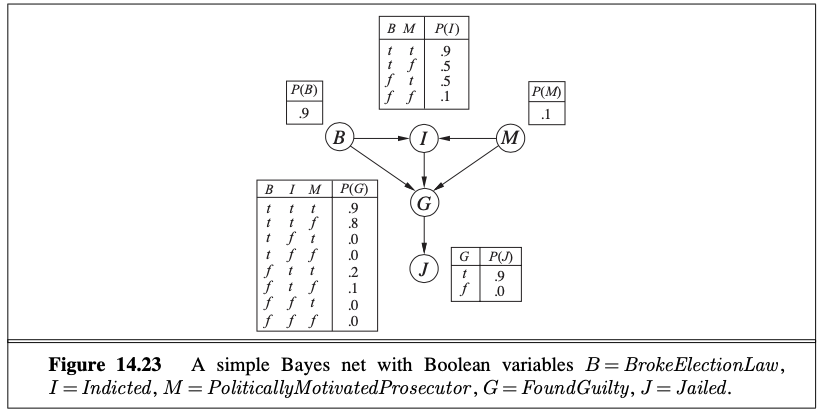

- **a**. Which of the following are asserted by the network structure?
  - (1) $P(B,I,M)=P(B)P(I)P(M)$
  - (2) $P(J|G)=P(J|G,I)$
  - (3) $P(M|G,B,I)=P(M|G,B,I,J)$
- **b**. calculate the value of $P(b,i,\neg m, g, j)$
- **c**. Calculate the probability that someone goes to jail given that they broke the law, have been indicted, and face a politically motivated prosecutor.
- **d**. Suppose we want to add the variable $P = PresidentialPardon$ to the network; draw the new network and briefly explain any links you add.







### PROBABILITY DISTRIBUTION
Let us begin by specifying discrete probability distributions. The class **ProbDist** defines a discrete probability distribution. We name our random variable and then assign probabilities to the different values of the random variable. Assigning probabilities to the values works similar to that of using a dictionary with keys being the Value and we assign to it the probability. This is possible because of the magic methods _ getitem _ and _ setitem _ which store the probabilities in the prob dict of the object. You can keep the source window open alongside while playing with the rest of the code to get a better understanding.

In [38]:
import numpy as np

class ProbDist:
    """A discrete probability distribution. You name the random variable
    in the constructor, then assign and query probability of values.
    >>> P = ProbDist('Flip'); P['H'], P['T'] = 0.25, 0.75; P['H']
    0.25
    >>> P = ProbDist('X', {'lo': 125, 'med': 375, 'hi': 500})
    >>> P['lo'], P['med'], P['hi']
    (0.125, 0.375, 0.5)
    """

    def __init__(self, varname='?', freqs=None):
        """If freqs is given, it is a dictionary of values - frequency pairs,
        then ProbDist is normalized."""
        self.prob = {}
        self.varname = varname
        self.values = []
        if freqs:
            for (v, p) in freqs.items():
                self[v] = p
            self.normalize()

    def __getitem__(self, val):
        """Given a value, return P(value)."""
        try:
            return self.prob[val]
        except KeyError:
            return 0

    def __setitem__(self, val, p):
        """Set P(val) = p."""
        if val not in self.values:
            self.values.append(val)
        self.prob[val] = p

    def normalize(self):
        """Make sure the probabilities of all values sum to 1.
        Returns the normalized distribution.
        Raises a ZeroDivisionError if the sum of the values is 0."""
        total = sum(self.prob.values())
        if not np.isclose(total, 1.0):
            for val in self.prob:
                self.prob[val] /= total
        return self

    def show_approx(self, numfmt='{:.3g}'):
        """Show the probabilities rounded and sorted by key, for the
        sake of portable doctests."""
        return ', '.join([('{}: ' + numfmt).format(v, p)
                          for (v, p) in sorted(self.prob.items())])

    def __repr__(self):
        return "P({})".format(self.varname)

### Joint Probability Distribution
The helper function **event_values** returns a tuple of the values of variables in event. An event is specified by a dict where the keys are the names of variables and the corresponding values are the value of the variable. Variables are specified with a list. The ordering of the returned tuple is same as those of the variables.

Alternatively if the event is specified by a list or tuple of equal length of the variables. Then the events tuple is returned as it is.

In [39]:
def event_values(event, variables):
    """Return a tuple of the values of variables in event.
    >>> event_values ({'A': 10, 'B': 9, 'C': 8}, ['C', 'A'])
    (8, 10)
    >>> event_values ((1, 2), ['C', 'A'])
    (1, 2)
    """
    if isinstance(event, tuple) and len(event) == len(variables):
        return event
    else:
        return tuple([event[var] for var in variables])

A probability model is completely determined by the joint distribution for all of the random variables. (Section 13.3) The probability module implements these as the class **JointProbDist** which inherits from the ProbDist class. This class specifies a discrete probability distribute over a set of variables.

In [40]:
class JointProbDist(ProbDist):
    """A discrete probability distribute over a set of variables.
    >>> P = JointProbDist(['X', 'Y']); P[1, 1] = 0.25
    >>> P[1, 1]
    0.25
    >>> P[dict(X=0, Y=1)] = 0.5
    >>> P[dict(X=0, Y=1)]
    0.5"""

    def __init__(self, variables):
        self.prob = {}
        self.variables = variables
        self.vals = defaultdict(list)

    def __getitem__(self, values):
        """Given a tuple or dict of values, return P(values)."""
        values = event_values(values, self.variables)
        return ProbDist.__getitem__(self, values)

    def __setitem__(self, values, p):
        """Set P(values) = p.  Values can be a tuple or a dict; it must
        have a value for each of the variables in the joint. Also keep track
        of the values we have seen so far for each variable."""
        values = event_values(values, self.variables)
        self.prob[values] = p
        for var, val in zip(self.variables, values):
            if val not in self.vals[var]:
                self.vals[var].append(val)

    def values(self, var):
        """Return the set of possible values for a variable."""
        return self.vals[var]

    def __repr__(self):
        return "P({})".format(self.variables)

### BAYESIAN NETWORKS
A Bayesian network is a representation of the joint probability distribution encoding a collection of conditional independence statements.

A Bayes Network is implemented as the class BayesNet. It consisits of a collection of nodes implemented by the class BayesNode. The implementation in the above mentioned classes focuses only on boolean variables. Each node is associated with a variable and it contains a conditional probabilty table (cpt). The cpt represents the probability distribution of the variable conditioned on its parents P(X | parents).

Let us dive into the **BayesNode** implementation.

In [41]:
class BayesNode:
    """A conditional probability distribution for a boolean variable,
    P(X | parents). Part of a BayesNet."""

    def __init__(self, X, parents, cpt):
        """X is a variable name, and parents a sequence of variable
        names or a space-separated string.  cpt, the conditional
        probability table, takes one of these forms:

        * A number, the unconditional probability P(X=true). You can
          use this form when there are no parents.

        * A dict {v: p, ...}, the conditional probability distribution
          P(X=true | parent=v) = p. When there's just one parent.

        * A dict {(v1, v2, ...): p, ...}, the distribution P(X=true |
          parent1=v1, parent2=v2, ...) = p. Each key must have as many
          values as there are parents. You can use this form always;
          the first two are just conveniences.

        In all cases the probability of X being false is left implicit,
        since it follows from P(X=true).

        >>> X = BayesNode('X', '', 0.2)
        >>> Y = BayesNode('Y', 'P', {T: 0.2, F: 0.7})
        >>> Z = BayesNode('Z', 'P Q',
        ...    {(T, T): 0.2, (T, F): 0.3, (F, T): 0.5, (F, F): 0.7})
        """
        if isinstance(parents, str):
            parents = parents.split()

        # We store the table always in the third form above.
        if isinstance(cpt, (float, int)):  # no parents, 0-tuple
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # one parent, 1-tuple
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v,): p for v, p in cpt.items()}

        assert isinstance(cpt, dict)
        for vs, p in cpt.items():
            assert isinstance(vs, tuple) and len(vs) == len(parents)
            assert all(isinstance(v, bool) for v in vs)
            assert 0 <= p <= 1

        self.variable = X
        self.parents = parents
        self.cpt = cpt
        self.children = []

    def p(self, value, event):
        """Return the conditional probability
        P(X=value | parents=parent_values), where parent_values
        are the values of parents in event. (event must assign each
        parent a value.)
        >>> bn = BayesNode('X', 'Burglary', {T: 0.2, F: 0.625})
        >>> bn.p(False, {'Burglary': False, 'Earthquake': True})
        0.375"""
        assert isinstance(value, bool)
        ptrue = self.cpt[event_values(event, self.parents)]
        return ptrue if value else 1 - ptrue
    def sample(self, event):
        """Sample from the distribution for this variable conditioned
        on event's values for parent_variables. That is, return True/False
        at random according with the conditional probability given the
        parents."""
        return probability(self.p(True, event))

    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))

The constructor takes in the name of **variable**, **parents** and **cpt**. Here variable is a the name of the variable like 'Earthquake'. parents should a list or space separate string with variable names of parents. The conditional probability table is a dict {(v1, v2, ...): p, ...}, the distribution P(X=true | parent1=v1, parent2=v2, ...) = p. Here the keys are combination of boolean values that the parents take. The length and order of the values in keys should be same as the supplied parent list/string. In all cases the probability of X being false is left implicit, since it follows from P(X=true).

The example below where we implement the network shown in Figure 14.3 of the book will make this more clear.
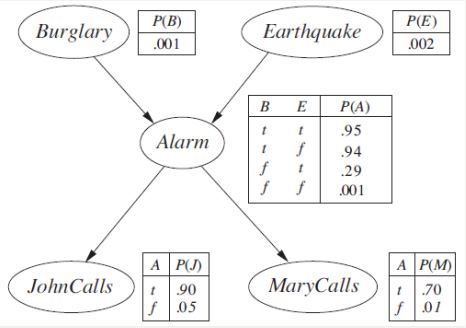

The alarm node can be made as follows:

In [42]:
alarm_node = BayesNode('Alarm', ['Burglary', 'Earthquake'], 
                       {(True, True): 0.95,(True, False): 0.94, (False, True): 0.29, (False, False): 0.001})

It is possible to avoid using a tuple when there is only a single parent. So an alternative format for the cpt is

In [43]:
john_node = BayesNode('JohnCalls', ['Alarm'], {True: 0.90, False: 0.05})
mary_node = BayesNode('MaryCalls', 'Alarm', {(True, ): 0.70, (False, ): 0.01}) # Using string for parents.
# Equivalant to john_node definition.

The general format used for the alarm node always holds. For nodes with no parents we can also use.

In [44]:
burglary_node = BayesNode('Burglary', '', 0.001)
earthquake_node = BayesNode('Earthquake', '', 0.002)

It is possible to use the node for lookup function using the p method. The method takes in two arguments value and event. Event must be a dict of the type {variable:values, ..} The value corresponds to the value of the variable we are interested in (False or True).The method returns the conditional probability P(X=value | parents=parent_values), where parent_values are the values of parents in event. (event must assign each parent a value.)

In [45]:
john_node.p(False, {'Alarm': True, 'Burglary': True}) # P(JohnCalls=False | Alarm=True)

0.09999999999999998

With all the information about nodes present it is possible to construct a Bayes Network using **BayesNet**. The BayesNet class does not take in nodes as input but instead takes a list of node_specs. An entry in node_specs is a tuple of the parameters we use to construct a BayesNode namely (X, parents, cpt). node_specs must be ordered with parents before children.



In [46]:
class BayesNet:
    """Bayesian network containing only boolean-variable nodes."""

    def __init__(self, node_specs=None):
        """Nodes must be ordered with parents before children."""
        self.nodes = []
        self.variables = []
        node_specs = node_specs or []
        for node_spec in node_specs:
            self.add(node_spec)

    def add(self, node_spec):
        """Add a node to the net. Its parents must already be in the
        net, and its variable must not."""
        node = BayesNode(*node_spec)
        assert node.variable not in self.variables
        assert all((parent in self.variables) for parent in node.parents)
        self.nodes.append(node)
        self.variables.append(node.variable)
        for parent in node.parents:
            self.variable_node(parent).children.append(node)

    def variable_node(self, var):
        """Return the node for the variable named var.
        >>> burglary.variable_node('Burglary').variable
        'Burglary'"""
        for n in self.nodes:
            if n.variable == var:
                return n
        raise Exception("No such variable: {}".format(var))

    def variable_values(self, var):
        """Return the domain of var."""
        return [True, False]

    def __repr__(self):
        return 'BayesNet({0!r})'.format(self.nodes)

The constructor of BayesNet takes each item in **node_specs** and adds a **BayesNode** to its nodes object variable by calling the add method. add in turn adds node to the net. Its parents must already be in the net, and its variable must not. Thus add allows us to grow a BayesNet given its parents are already present.

burglary global is an instance of BayesNet corresponding to the above example.

In [47]:
T, F = True, False

burglary = BayesNet([
    ('Burglary', '', 0.001),
    ('Earthquake', '', 0.002),
    ('Alarm', 'Burglary Earthquake',
     {(T, T): 0.95, (T, F): 0.94, (F, T): 0.29, (F, F): 0.001}),
    ('JohnCalls', 'Alarm', {T: 0.90, F: 0.05}),
    ('MaryCalls', 'Alarm', {T: 0.70, F: 0.01})
])

In [48]:
burglary

BayesNet([('Burglary', ''), ('Earthquake', ''), ('Alarm', 'Burglary Earthquake'), ('JohnCalls', 'Alarm'), ('MaryCalls', 'Alarm')])

**BayesNet** method variable_node allows to reach BayesNode instances inside a Bayes Net. It is possible to modify the cpt of the nodes directly using this method.

In [49]:
type(burglary.variable_node('Alarm'))

__main__.BayesNode

In [50]:
burglary.variable_node('Alarm').cpt

{(True, True): 0.95,
 (True, False): 0.94,
 (False, True): 0.29,
 (False, False): 0.001}

### Exact Inference in Bayesian Networks
A Bayes Network is a more compact representation of the full joint distribution and like full joint distributions allows us to do inference i.e. answer questions about probability distributions of random variables given some evidence.

Exact algorithms don't scale well for larger networks. Approximate algorithms are explained in the next section.

#### Inference by Enumeration
We apply techniques similar to those used for **enumerate_joint_ask** and **enumerate_joint** to draw inference from Bayesian Networks. enumeration_ask and enumerate_all implement the algorithm described in Figure 14.9 of the book.

In [51]:
def enumerate_all(variables, e, bn):
    """Return the sum of those entries in P(variables | e{others})
    consistent with e, where P is the joint distribution represented
    by bn, and e{others} means e restricted to bn's other variables
    (the ones other than variables). Parents must precede children in variables."""
    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    Ynode = bn.variable_node(Y)
    if Y in e:
        return Ynode.p(e[Y], e) * enumerate_all(rest, e, bn)
    else:
        return sum(Ynode.p(y, e) * enumerate_all(rest, extend(e, Y, y), bn)
                   for y in bn.variable_values(Y))

enumerate_all recursively evaluates a general form of the Equation 14.4 in the book.

$$\textbf{P}(X | \textbf{e}) = α \textbf{P}(X, \textbf{e}) = α \sum_{y} \textbf{P}(X, \textbf{e}, \textbf{y})$$
such that P(X, e, y) is written in the form of product of conditional probabilities P(variable | parents(variable)) from the Bayesian Network.

enumeration_ask calls enumerate_all on each value of query variable X and finally normalizes them.

In [52]:
def enumeration_ask(X, e, bn):
    """Return the conditional probability distribution of variable X
    given evidence e, from BayesNet bn. [Figure 14.9]
    >>> enumeration_ask('Burglary', dict(JohnCalls=T, MaryCalls=T), burglary
    ...  ).show_approx()
    'False: 0.716, True: 0.284'"""
    assert X not in e, "Query variable must be distinct from evidence"
    Q = ProbDist(X)
    for xi in bn.variable_values(X):
        Q[xi] = enumerate_all(bn.variables, extend(e, X, xi), bn)
    return Q.normalize()

def extend(s, var, val):
    """Copy dict s and extend it by setting var to val; return copy."""
    return {**s, var: val}

Let us solve the problem of finding out **P(Burglary=True | JohnCalls=True, MaryCalls=True)** using the burglary network. enumeration_ask takes three arguments X = variable name, e = Evidence (in form a dict like previously explained), bn = The Bayes Net to do inference on.

In [53]:
ans_dist = enumeration_ask('Burglary', {'JohnCalls': True, 'MaryCalls': True}, burglary)
ans_dist[True]

0.2841718353643929

#### Variable Elimination

The enumeration algorithm can be improved substantially by eliminating repeated calculations. In enumeration we join the joint of all hidden variables. This is of exponential size for the number of hidden variables. Variable elimination employes interleaving join and marginalization.

Before we look into the implementation of Variable Elimination we must first familiarize ourselves with Factors.

In general we call a multidimensional array of type P(Y1 ... Yn | X1 ... Xm) a factor where some of Xs and Ys maybe assigned values. Factors are implemented in the probability module as the class **Factor**. They take as input variables and cpt.

##### Helper Functions
There are certain helper functions that help creating the cpt for the Factor given the evidence. Let us explore them one by one.

In [54]:
class Factor:
    """A factor in a joint distribution."""

    def __init__(self, variables, cpt):
        self.variables = variables
        self.cpt = cpt

    def pointwise_product(self, other, bn):
        """Multiply two factors, combining their variables."""
        variables = list(set(self.variables) | set(other.variables))
        cpt = {event_values(e, variables): self.p(e) * other.p(e) for e in all_events(variables, bn, {})}
        return Factor(variables, cpt)

    def sum_out(self, var, bn):
        """Make a factor eliminating var by summing over its values."""
        variables = [X for X in self.variables if X != var]
        cpt = {event_values(e, variables): sum(self.p(extend(e, var, val)) for val in bn.variable_values(var))
               for e in all_events(variables, bn, {})}
        return Factor(variables, cpt)

    def normalize(self):
        """Return my probabilities; must be down to one variable."""
        assert len(self.variables) == 1
        return ProbDist(self.variables[0], {k: v for ((k,), v) in self.cpt.items()})

    def p(self, e):
        """Look up my value tabulated for e."""
        return self.cpt[event_values(e, self.variables)]

def make_factor(var, e, bn):
    """Return the factor for var in bn's joint distribution given e.
    That is, bn's full joint distribution, projected to accord with e,
    is the pointwise product of these factors for bn's variables."""
    node = bn.variable_node(var)
    variables = [X for X in [var] + node.parents if X not in e]
    cpt = {event_values(e1, variables): node.p(e1[var], e1)
           for e1 in all_events(variables, bn, e)}
    return Factor(variables, cpt)

**make_factor** is used to create the cpt and variables that will be passed to the constructor of **Factor**. We use make_factor for each variable. It takes in the arguments var the particular variable, e the evidence we want to do inference on, bn the bayes network.

Here variables for each node refers to a list consisting of the variable itself and the parents minus any variables that are part of the evidence. This is created by finding the node.parents and filtering out those that are not part of the evidence.

The **cpt** created is the one similar to the original cpt of the node with only rows that agree with the evidence.

In [55]:
def all_events(variables, bn, e):
    """Yield every way of extending e with values for all variables."""
    if not variables:
        yield e
    else:
        X, rest = variables[0], variables[1:]
        for e1 in all_events(rest, bn, e):
            for x in bn.variable_values(X):
                yield extend(e1, X, x)

The **all_events** function is a recursive generator function which yields a key for the orignal cpt which is part of the node. This works by extending evidence related to the node, thus all the output from all_events only includes events that support the evidence. Given all_events is a generator function one such event is returned on every call.

We can try this out using the example on Page 524 of the book. We will make f5(A) = P(m | A)

In [58]:
f5 = make_factor('MaryCalls', {'JohnCalls': True, 'MaryCalls': True}, burglary)

In [59]:
f5

In [60]:
f5.cpt

{(True,): 0.7, (False,): 0.01}

In [61]:
f5.variables

['Alarm']

Here f5.cpt False key gives probability for **P(MaryCalls=True | Alarm = False)**. Due to our representation where we only store probabilities for only in cases where the node variable is True this is the same as the cpt of the BayesNode. Let us try a somewhat different example from the book where evidence is that the Alarm = True

In [62]:
new_factor = make_factor('MaryCalls', {'Alarm': True}, burglary)

In [63]:
new_factor.cpt

{(True,): 0.7, (False,): 0.30000000000000004}

Here the cpt is for **P(MaryCalls | Alarm = True)**. Therefore the probabilities for True and False sum up to one. Note the difference between both the cases. Again the only rows included are those consistent with the evidence.

##### Operations on Factors
We are interested in two kinds of operations on factors. **Pointwise Product** which is used to created joint distributions and **Summing Out** which is used for marginalization.

**Factor.pointwise_product** implements a method of creating a joint via combining two factors. We take the union of **variables** of both the factors and then generate the **cpt** for the new factor using **all_events** function. Note that the given we have eliminated rows that are not consistent with the evidence. Pointwise product assigns new probabilities by multiplying rows similar to that in a database join.

**Factor.sum_out** makes a factor eliminating a variable by summing over its values. Again **events_all** is used to generate combinations for the rest of the variables.

In the next, **pointwise_product** extends the operation of **Factor.pointwise_product** to more than two operands where it is done sequentially in pairs of two.

**sum_out** uses both **Factor.sum_out** and **pointwise_product** to finally eliminate a particular variable from all factors by summing over its values.

In [64]:
def pointwise_product(factors, bn):
    return reduce(lambda f, g: f.pointwise_product(g, bn), factors)

def sum_out(var, factors, bn):
    """Eliminate var from all factors by summing over its values."""
    result, var_factors = [], []
    for f in factors:
        (var_factors if var in f.variables else result).append(f)
    result.append(pointwise_product(var_factors, bn).sum_out(var, bn))
    return result

##### Elimination Ask
The algorithm described in Figure 14.11 of the book is implemented by the function **elimination_ask**. We use this for inference. The key idea is that we eliminate the hidden variables by interleaving joining and marginalization. It takes in 3 arguments X the query variable, e the evidence variable and bn the Bayes network.

The algorithm creates factors out of Bayes Nodes in reverse order and eliminates hidden variables using sum_out. Finally it takes a point wise product of all factors and normalizes. Let us finally solve the problem of inferring

**P(Burglary=True | JohnCalls=True, MaryCalls=True)** using variable elimination.

In [69]:
from functools import reduce

def is_hidden(var, X, e):
    """Is var a hidden variable when querying P(X|e)?"""
    return var != X and var not in e

def elimination_ask(X, e, bn):
    """Compute bn's P(X|e) by variable elimination. [Figure 14.11]
    >>> elimination_ask('Burglary', dict(JohnCalls=T, MaryCalls=T), burglary
    ...  ).show_approx()
    'False: 0.716, True: 0.284'"""
    assert X not in e, "Query variable must be distinct from evidence"
    factors = []
    for var in reversed(bn.variables):
        factors.append(make_factor(var, e, bn))
        if is_hidden(var, X, e):
            factors = sum_out(var, factors, bn)
    return pointwise_product(factors, bn).normalize()

In [70]:
elimination_ask('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary).show_approx()

'False: 0.716, True: 0.284'

### Approximate Inference in Bayesian Networks

Exact inference fails to scale for very large and complex Bayesian Networks. This section covers implementation of randomized sampling algorithms, also called Monte Carlo algorithms.


Before we consider the different algorithms in this section let us look at the **BayesNode.sample** method. It samples from the distribution for this variable conditioned on event's values for parent_variables. That is, return True/False at random according to with the conditional probability given the parents. The **probability** function is a simple helper from utils module which returns True with the probability passed to it.

#### Prior Sampling
The idea of Prior Sampling is to sample from the Bayesian Network in a topological order. We start at the top of the network and sample as per **P(Xi | parents(Xi))** i.e. the probability distribution from which the value is sampled is conditioned on the values already assigned to the variable's parents. This can be thought of as a simulation.

In [76]:
import random 

def probability(p):
    """Return true with probability p."""
    return p > random.uniform(0.0, 1.0)

def prior_sample(bn):
    """Randomly sample from bn's full joint distribution. The result
    is a {variable: value} dict. [Figure 14.13]"""
    event = {}
    for node in bn.nodes:
        event[node.variable] = node.sample(event)
    return event

The function **prior_sample** implements the algorithm described in Figure 14.13 of the book. Nodes are sampled in the topological order. The old value of the event is passed as evidence for parent values. We will use the Bayesian Network in Figure 14.12 to try out the prior_sample

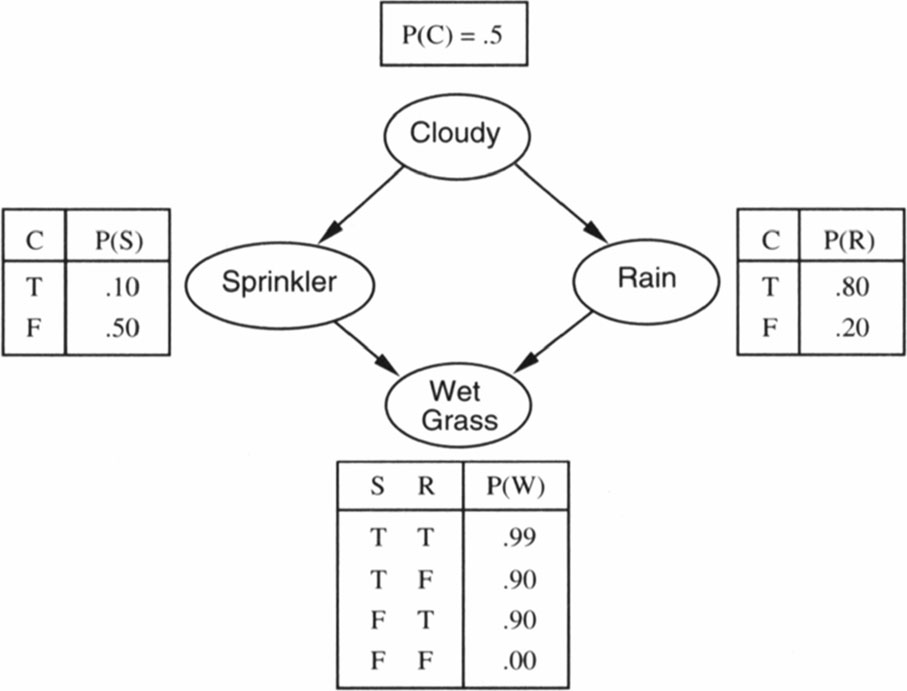

Traversing the graph in topological order is important. There are two possible topological orderings for this particular directed acyclic graph.

- Cloudy -> Sprinkler -> Rain -> Wet Grass
- Cloudy -> Rain -> Sprinkler -> Wet Grass

We can follow any of the two orderings to sample from the network. Any ordering other than these two, however, cannot be used.
One way to think about this is that Cloudy can be seen as a precondition of both Rain and Sprinkler and just like we have seen in planning, preconditions need to be satisfied before a certain action can be executed.
We store the samples on the observations. Let us find **P(Rain=True)** by taking 1000 random samples from the network.

In [77]:
N = 1000

sprinkler = BayesNet([('Cloudy', '', 0.5),
                      ('Sprinkler', 'Cloudy', {T: 0.10, F: 0.50}),
                      ('Rain', 'Cloudy', {T: 0.80, F: 0.20}),
                      ('WetGrass', 'Sprinkler Rain',
                       {(T, T): 0.99, (T, F): 0.90, (F, T): 0.90, (F, F): 0.00})])

all_observations = [prior_sample(sprinkler) for x in range(N)]

Now we filter to get the observations where Rain = True

In [78]:
rain_true = [observation for observation in all_observations if observation['Rain'] == True]

Finally, we can find **P(Rain=True)**

In [79]:
answer = len(rain_true) / N
print(answer)

0.5


Sampling this another time might give different results as we have no control over the distribution of the random samples

In [80]:
N = 1000
all_observations = [prior_sample(sprinkler) for x in range(N)]
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
answer = len(rain_true) / N
print(answer)

0.486


To evaluate a conditional distribution. We can use a two-step filtering process. We first separate out the variables that are consistent with the evidence. Then for each value of query variable, we can find probabilities. For example to find **P(Cloudy=True | Rain=True)**. We have already filtered out the values consistent with our evidence in **rain_true**. Now we apply a second filtering step on rain_true to find **P(Rain=True and Cloudy=True)**

In [81]:
rain_and_cloudy = [observation for observation in rain_true if observation['Cloudy'] == True]
answer = len(rain_and_cloudy) / len(rain_true)
print(answer)

0.8065843621399177


#### Rejection Sampling

Rejection Sampling is based on an idea similar to what we did just now. First, it generates samples from the prior distribution specified by the network. Then, it rejects all those that do not match the evidence.
Rejection sampling is advantageous only when we know the query beforehand. While prior sampling generally works for any query, it might fail in some scenarios.
Let's say we have a generic Bayesian network and we have evidence e, and we want to know how many times a state A is true, given evidence e is true. Normally, prior sampling can answer this question, but let's assume that the probability of evidence e being true in our actual probability distribution is very small. In this situation, it might be possible that sampling never encounters a data-point where e is true. If our sampled data has no instance of e being true, P(e) = 0, and therefore P(A | e) / P(e) = 0/0, which is undefined. We cannot find the required value using this sample.
We can definitely increase the number of sample points, but we can never guarantee that we will encounter the case where e is non-zero (assuming our actual probability distribution has atleast one case where e is true). To guarantee this, we would have to consider every single data point, which means we lose the speed advantage that approximation provides us and we essentially have to calculate the exact inference model of the Bayesian network.

Rejection sampling will be useful in this situation, as we already know the query.
While sampling from the network, we will reject any sample which is inconsistent with the evidence variables of the given query (in this example, the only evidence variable is e). We will only consider samples that do not violate any of the evidence variables. In this way, we will have enough data with the required evidence to infer queries involving a subset of that evidence.

The function rejection_sampling implements the algorithm described by Figure 14.14

In [82]:
def rejection_sampling(X, e, bn, N=10000):
    """Estimate the probability distribution of variable X given
    evidence e in BayesNet bn, using N samples.  [Figure 14.14]
    Raises a ZeroDivisionError if all the N samples are rejected,
    i.e., inconsistent with e.
    >>> random.seed(47)
    >>> rejection_sampling('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.7, True: 0.3'
    """
    counts = {x: 0 for x in bn.variable_values(X)}  # bold N in [Figure 14.14]
    for j in range(N):
        sample = prior_sample(bn)  # boldface x in [Figure 14.14]
        if consistent_with(sample, e):
            counts[sample[X]] += 1
    return ProbDist(X, counts)

The function keeps counts of each of the possible values of the Query variable and increases the count when we see an observation consistent with the evidence. It takes in input parameters X - The Query Variable, e - evidence, bn - Bayes net and N - number of prior samples to generate.

**consistent_with** is used to check consistency.

In [84]:
def consistent_with(event, evidence):
    """Is event consistent with the given evidence?"""
    return all(evidence.get(k, v) == v
               for k, v in event.items())

To answer **P(Cloudy=True | Rain=True)**

In [85]:
p = rejection_sampling('Cloudy', dict(Rain=True), sprinkler, 1000)
p[True]

0.7995991983967936

#### Likelihood Weighting

Rejection sampling takes a long time to run when the probability of finding consistent evidence is low. It is also slow for larger networks and more evidence variables. Rejection sampling tends to reject a lot of samples if our evidence consists of a large number of variables. Likelihood Weighting solves this by fixing the evidence (i.e. not sampling it) and then using weights to make sure that our overall sampling is still consistent.

The pseudocode in Figure 14.15 is implemented as **likelihood_weighting** and **weighted_sample**.

In [86]:
def weighted_sample(bn, e):
    """Sample an event from bn that's consistent with the evidence e;
    return the event and its weight, the likelihood that the event
    accords to the evidence."""
    w = 1
    event = dict(e)  # boldface x in [Figure 14.15]
    for node in bn.nodes:
        Xi = node.variable
        if Xi in e:
            w *= node.p(e[Xi], event)
        else:
            event[Xi] = node.sample(event)
    return event, w

**weighted_sample** samples an event from Bayesian Network that's consistent with the evidence e and returns the event and its weight, the likelihood that the event accords to the evidence. It takes in two parameters bn the Bayesian Network and e the evidence.

The weight is obtained by multiplying **P(xi | parents(xi))** for each node in evidence. We set the values of **event = evidence** at the start of the function.

In [87]:
weighted_sample(sprinkler, dict(Rain=True))


({'Rain': True, 'Cloudy': True, 'Sprinkler': False, 'WetGrass': True}, 0.8)

In [88]:
def likelihood_weighting(X, e, bn, N=10000):
    """Estimate the probability distribution of variable X given
    evidence e in BayesNet bn.  [Figure 14.15]
    >>> random.seed(1017)
    >>> likelihood_weighting('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.702, True: 0.298'
    """
    W = {x: 0 for x in bn.variable_values(X)}
    for j in range(N):
        sample, weight = weighted_sample(bn, e)  # boldface x, w in [Figure 14.15]
        W[sample[X]] += weight
    return ProbDist(X, W)

**likelihood_weighting** implements the algorithm to solve our inference problem. The code is similar to **rejection_sampling** but instead of adding one for each sample we add the weight obtained from **weighted_sampling**.

In [89]:
likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

'False: 0.216, True: 0.784'

#### Gibbs Sampling

In likelihood sampling, it is possible to obtain low weights in cases where the evidence variables reside at the bottom of the Bayesian Network. This can happen because influence only propagates downwards in likelihood sampling.

Gibbs Sampling solves this. The implementation of Figure 14.16 is provided in the function **gibbs_ask**

In [132]:
def gibbs_ask(X, e, bn, N=1000):
    """[Figure 14.16]"""
    assert X not in e, "Query variable must be distinct from evidence"
    counts = {x: 0 for x in bn.variable_values(X)}  # bold N in [Figure 14.16]
    Z = [var for var in bn.variables if var not in e]
    state = dict(e)  # boldface x in [Figure 14.16]
    for Zi in Z:
        state[Zi] = random.choice(bn.variable_values(Zi))
    for j in range(N):
        for Zi in Z:
            state[Zi] = markov_blanket_sample(Zi, state, bn)
            counts[state[X]] += 1
    return ProbDist(X, counts)

def product(numbers):
    """Return the product of the numbers, e.g. product([2, 3, 10]) == 60"""
    result = 1
    for x in numbers:
        result *= x
    return result

def markov_blanket_sample(X, e, bn):
    """Return a sample from P(X | mb) where mb denotes that the
    variables in the Markov blanket of X take their values from event
    e (which must assign a value to each). The Markov blanket of X is
    X's parents, children, and children's parents."""
    Xnode = bn.variable_node(X)
    Q = ProbDist(X)
    for xi in bn.variable_values(X):
        ei = extend(e, X, xi)
        # [Equation 14.12]
        Q[xi] = Xnode.p(xi, e) * product(Yj.p(ei[Yj.variable], ei) for Yj in Xnode.children)
    # (assuming a Boolean variable here)
    return probability(Q.normalize()[True])

In **gibbs_ask** we initialize the non-evidence variables to random values. And then select non-evidence variables and sample it from **P(Variable | value in the current state of all remaining vars)** repeatedly sample. In practice, we speed this up by using **markov_blanket_sample** instead. This works because terms not involving the variable get canceled in the calculation. The arguments for **gibbs_ask** are similar to **likelihood_weighting**

In [133]:
gibbs_ask('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

'False: 0.225, True: 0.775'